# Unsupervised Learning: Clustering Lab





In [51]:
from sklearn.base import BaseEstimator, ClassifierMixin, ClusterMixin
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import arff
import pandas as pd
from IPython.core.display import display
import pprint
pp = pprint.PrettyPrinter(indent=4)
from scipy.spatial.distance import cdist
import gc
from sklearn.metrics import silhouette_score
import copy
import time
from numpy.random import default_rng

In [2]:
# HELPER FUNCTIONS

def load_data(filename):
    data = arff.loadarff(filename)
    df = pd.DataFrame(data[0])

    for i in range(len(df.dtypes)):
        if df.dtypes.astype(str).iloc[i] == 'object':
            column = df.columns[i]
            df[column] = df[column] \
                            .astype(str).str \
                            .split("\'", expand=True) \
                            .iloc[:,1]
    return df

def normalize(data):
    # (x-xmin)/(xmax-xmin)
    return (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))

## 1. (50%) Implement the k-means clustering algorithm and the HAC (Hierarchical Agglomerative Clustering) algorithm.

### 1.1.1 HAC

### Code requirements 
- HAC should support both single link and complete link options.
- HAC automatically generates all clusterings from n to 1.  To simplify the amount of output you may want to implement a mechanism to specify for which k values actual output will be generated.


---
The output should include the following:
- The number of clusters (k).
- The silhouette score of the full clustering. (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
---

In [20]:
class HACClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,link_type='single'): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            link_type = single or complete. when combining two clusters use complete link or single link
        """
        self.link_type = link_type
        self.k = k
        self.clusters = []
        
    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """

        # Put all instances in their own cluster
        if y is not None:
            if len(y.shape) == 1:
                X = np.append(X, y.reshape(-1,1), axis=1)
            elif len(y.shape) > 1:
                X = np.append(X, y, axis=1)
                
        self.init_clusters(X)

        # Remember number of samples and number of features
        self.n_samples, self.n_features = X.shape[0], X.shape[1]

        # Combine clusters one at a time until desired cluster count is reached
        while len(self.clusters) > self.k:
            gc.collect()
            self.combine_two_clusters()

        self.calculate_sse()
        self.calc_silhouette_score()

        return self

    def combine_two_clusters(self):
        
        min_cluster_dist = np.inf
        min_dist_clusters_inds = (None, None)

        for i in range(len(self.clusters)):
            for j in range(len(self.clusters)):
                if i == j: continue

                c1 = self.clusters[i]
                c2 = self.clusters[j]
                distance_metric = self.cluster_distance(c1, c2)

                if distance_metric < min_cluster_dist:
                    min_cluster_dist = distance_metric
                    min_dist_clusters_inds = (i, j)

        new_clusters = []
        c1,  c2 = self.clusters[min_dist_clusters_inds[0]], \
            self.clusters[min_dist_clusters_inds[1]]
        combined_cluster = np.append(c1, c2, axis=0)
        new_clusters.append(combined_cluster)

        for ind in range(len(self.clusters)):
            if ind != min_dist_clusters_inds[0] and ind != min_dist_clusters_inds[1]:
                new_clusters.append(self.clusters[ind])

        self.clusters = new_clusters

    def calculate_sse(self):
        self.cluster_sses = []

        for cluster in self.clusters:
            centroid = np.mean(cluster, axis=0)
            dist = cdist(centroid.reshape(1,-1), cluster, metric='euclidean')
            dist = dist**2
            sse = np.sum(dist)
            self.cluster_sses.append(sse)
        
        self.total_sse = sum(self.cluster_sses)

    def calc_silhouette_score(self):
        self.data, self.labels = self._arr_clusters_labels()
        self.silhouette_score = silhouette_score(self.data, self.labels, metric='euclidean')

    def cluster_distance(self, c1, c2):
        dist = cdist( c1, c2, metric='euclidean' )  # -> (nx, ny) distances
        if self.link_type == 'single':
            return np.min(dist)
        elif self.link_type == 'complete':
            return np.max(dist)

    def init_clusters(self, instances):
        for i in range(instances.shape[0]):
            cluster = instances[i, :].reshape(1, -1)
            self.clusters.append(cluster)

    def _arr_clusters_labels(self):
        arr_clusters = np.zeros((self.n_samples, self.n_features))
        labels = np.zeros(self.n_samples)
        ptr = 0
        cluster_label = 0

        for cluster in self.clusters:
            n_cluster_samples = cluster.shape[0]
            arr_clusters[ptr:(ptr+n_cluster_samples)] = cluster
            labels[ptr:(ptr+n_cluster_samples)] = cluster_label
            cluster_label += 1
            ptr += cluster.shape[0]

        return arr_clusters, labels
    
    def print_clusters(self):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """

        print("Num clusters:\t\t{:d}".format(len(self.clusters)))
        print("SSE:\t\t\t{:.4f}\n\n".format(self.total_sse))
        for i in range(len(self.clusters)):
            cluster = self.clusters[i]
            centroid = np.mean(cluster, axis=0)
            print("Centroid:\t\t{}".format(np.array2string(centroid,precision=4,separator=",")))
            print("Num points:\t\t{:d}".format(cluster.shape[0]))
            print("SSE\t\t\t{:.4f}\n".format(self.cluster_sses[i]))

### 1.1.2 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


---
The dataset was modified to be a lot smaller. The last datapoint should be on line 359 or the point 0.585,0.46,0.185,0.922,0.3635,0.213,0.285,10. The remaining points should be commented out.


- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.


---
Solutions in files:

[Debug HAC Single (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Single%20Link%20%28Silhouette%29.txt)

[Debug HAC Complete (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Complete%20Link%20%28Silhouette%29.txt)

In [4]:
# Debug Here
dbDF = load_data("datasets/abalone.arff")
display(dbDF.head(2))
display(dbDF.tail(2))

X_db = dbDF.iloc[:, :-1].to_numpy()
y_db = dbDF.iloc[:, -1].to_numpy()

print(X_db.shape)
print(y_db.shape)

X_db = normalize(X_db)
y_db = normalize(y_db)

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7.0


,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
198,0.560,0.45,0.160,0.922,0.4320,0.178,0.260,15.0
199,0.585,0.46,0.185,0.922,0.3635,0.213,0.285,10.0


(200, 7)
(200,)


In [61]:
# Single Link
hac = HACClustering(k=5, link_type='single')
hac.fit(X_db, y_db)
hac.print_clusters()

Num clusters:		5
SSE:			54.4392


Centroid:		[0.599 ,0.5923,0.4915,0.2826,0.2682,0.2921,0.2316,0.3849]
Num points:		195
SSE			54.3917

Centroid:		[1.    ,0.9831,0.8026,0.8343,0.6575,0.7825,0.9221,0.8824]
Num points:		2
SSE			0.0475

Centroid:		[0.9189,0.9438,0.7105,0.7016,0.759 ,0.7222,0.4472,0.8824]
Num points:		1
SSE			0.0000

Centroid:		[1.    ,0.9888,0.7895,1.    ,1.    ,0.8915,0.7186,0.5882]
Num points:		1
SSE			0.0000

Centroid:		[0.9189,0.9888,0.8684,0.719 ,0.5797,0.7512,0.6432,0.9412]
Num points:		1
SSE			0.0000



In [62]:
# Complete Link
hac = HACClustering(k=5, link_type='complete')
hac.fit(X_db, y_db)
hac.print_clusters()

Num clusters:		5
SSE:			13.0824


Centroid:		[0.3661,0.3505,0.271 ,0.1008,0.1024,0.1058,0.0836,0.2116]
Num points:		67
SSE			5.2786

Centroid:		[0.6544,0.649 ,0.5256,0.2879,0.2815,0.3057,0.2288,0.3911]
Num points:		71
SSE			3.8232

Centroid:		[0.8818,0.8904,0.7582,0.614 ,0.5433,0.5317,0.561 ,0.7794]
Num points:		16
SSE			1.5328

Centroid:		[0.9471,0.934 ,0.8158,0.7457,0.6434,0.7944,0.6457,0.625 ]
Num points:		8
SSE			0.9490

Centroid:		[0.7622,0.7658,0.6759,0.4265,0.4016,0.4536,0.3376,0.5217]
Num points:		38
SSE			1.4989



### 1.1.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff)

- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.

#### 1.1.3.1 Complete Link

In [5]:
# Load evaluation data
evalDF = load_data("datasets/seismic-bumps_train.arff")
display(evalDF.head(2))
display(evalDF.tail(2))

evalDF['Class'] = evalDF['Class'].astype(float)

X_eval = evalDF.iloc[:, :-1].to_numpy()
y_eval = evalDF.iloc[:, -1].to_numpy()

print(X_eval.shape)
print(y_eval.shape)

X_eval = normalize(X_eval)
y_eval = normalize(y_eval)

,V1,V2,V3,V4,V5,V6,V7,Class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1


,V1,V2,V3,V4,V5,V6,V7,Class
138,15.60,15.11,0.858,5.832,3.286,2.725,5.752,2
139,16.23,15.18,0.885,5.872,3.472,3.769,5.922,2


(140, 7)
(140,)


#### 1.1.3.1 Single Link

In [64]:
# Train on evaluation data using single link
hac = HACClustering(k=5, link_type='single')
hac.fit(X_eval, y_eval)

# Print clusters
hac.print_clusters()

Num clusters:		5
SSE:			22.4548


Centroid:		[0.714 ,0.7588,0.5603,0.7028,0.6994,0.4864,0.7393,1.    ]
Num points:		70
SSE			12.4291

Centroid:		[0.3159,0.3648,0.5145,0.349 ,0.3338,0.3077,0.2868,0.    ]
Num points:		67
SSE			10.0257

Centroid:		[0.2774,0.2597,1.    ,0.1224,0.4505,0.7549,0.129 ,0.    ]
Num points:		1
SSE			0.0000

Centroid:		[0.3065,0.3333,0.6979,0.2792,0.3787,1.    ,0.2373,0.    ]
Num points:		1
SSE			0.0000

Centroid:		[0.0884,0.1818,0.    ,0.145 ,0.1538,0.1245,0.    ,0.    ]
Num points:		1
SSE			0.0000



### 1.2.1 K-Means

### Code requirements 
- Ability to choose k and specify k initial centroids
- Use Euclidean Distance as metric
- Ability to handle distance ties
- Include output label as a cluster feature


---
The output should include the following:
- The number of clusters (k).
- The silhouette score of the full clustering. (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
---
You only need to handle continuous features

In [79]:
class KMEANSClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,debug=False, tol=0, random_centroids=False): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            debug = if debug is true use the first k instances as the initial centroids otherwise choose random points as the initial centroids.
        """
        self.k = k
        self.debug = debug
        self.tol = tol
        self.random_centroids = random_centroids

    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        # Put all instances in their own cluster
        if y is not None:
            if len(y.shape) == 1:
                X = np.append(X, y.reshape(-1,1), axis=1)
            elif len(y.shape) > 1:
                X = np.append(X, y, axis=1)

        # Remember number of samples and number of features
        self.n_samples, self.n_features = X.shape[0], X.shape[1]

        # Store X as class variable
        self.data = X

        # Get centroids (first k instances)
        self.init_centroids()
        self.old_centroids = np.full(self.centroids.shape, np.inf)

        # Combine clusters one at a time until there is not change in centroids
        while np.max(np.abs(self.centroids - self.old_centroids)) > self.tol:
            gc.collect()
            self.iterate_centroids()

        self.calculate_silhouette_score()
        self.calculate_sse()

        return self

    def init_centroids(self):
        if self.random_centroids == True:
            # Sample k random centroids from instances in the data
            rng = default_rng()
            centroid_indxs = rng.choice(self.data.shape[0], size=self.k)
            self.centroids = np.copy(self.data[centroid_indxs])
        else:
            self.centroids = np.copy(self.data[:self.k, :])
    
    def iterate_centroids(self):
        self.old_centroids = np.copy(self.centroids)

        dist = cdist( self.centroids, self.data, metric='euclidean' )  # -> (nx, ny) distances
        self.labels = np.argmin(dist, axis=0) # Ties are broken by taking the first index

        for centroid_id in range(self.centroids.shape[0]):
            nearest_point_ids = np.where(self.labels == centroid_id)
            nearest_points = self.data[nearest_point_ids, :].squeeze(axis=0)
            if len(nearest_points) > 0:
                self.centroids[centroid_id, :] = np.mean(nearest_points, axis=0)

    def calculate_sse(self):
        self.cluster_sses = []
        
        for centroid_id in range(self.centroids.shape[0]):
            centroid = self.centroids[centroid_id, :]
            row_ind = np.where(self.labels == centroid_id)
            data = self.data[row_ind, :].squeeze(0)
            dist = cdist(centroid.reshape(1, -1), data)
            dist = dist**2
            sse = np.sum(dist)
            self.cluster_sses.append(sse)
        
        self.total_sse = sum(self.cluster_sses)
            
    def calculate_silhouette_score(self):
        # dist = cdist( self.centroids, self.data, metric='euclidean' )  # -> (nx, ny) distances
        # self.labels = np.argmin(dist, axis=0)
        self.silhouette_score = silhouette_score(self.data, self.labels, metric='euclidean')

    def print_clusters(self):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """

        print("Num clusters:\t\t{:d}".format(self.centroids.shape[0]))
        print("SSE:\t\t\t{:.4f}\n\n".format(self.total_sse))
        for i in range(self.centroids.shape[0]):
            centroid = self.centroids[i, :]
            print("Centroid:\t\t{}".format(np.array2string(centroid,precision=4,separator=",")))
            n_samples_cluster = len(np.where(self.labels == i)[0])
            print("Num points:\t\t{:d}".format(n_samples_cluster))
            print("SSE\t\t\t{:.4f}\n".format(self.cluster_sses[i]))

### 1.2.2 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values




---
Solutions in files:

[Debug K Means (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20K%20Means%20%28Silhouette%29.txt)

In [78]:
# Debug Here
dbDF = load_data("datasets/abalone.arff")

X_db = dbDF.iloc[:, :-1].to_numpy()
y_db = dbDF.iloc[:, -1].to_numpy()

X_db = normalize(X_db)
y_db = normalize(y_db)

# Train on debug data
kmeans = KMEANSClustering(k=5)
kmeans.fit(X_db, y_db)

# Print clusters
kmeans.print_clusters()

Num clusters:		5
SSE:			9.7826


Centroid:		[0.7325,0.7327,0.627 ,0.3817,0.3633,0.4045,0.3046,0.4839]
Num points:		75
SSE			4.0454

Centroid:		[0.3704,0.3519,0.2686,0.0926,0.0935,0.094 ,0.0792,0.218 ]
Num points:		34
SSE			0.6609

Centroid:		[0.9035,0.905 ,0.7774,0.6579,0.5767,0.6193,0.5893,0.7279]
Num points:		24
SSE			3.2116

Centroid:		[0.5692,0.5628,0.4376,0.211 ,0.2113,0.2248,0.1659,0.317 ]
Num points:		54
SSE			1.5452

Centroid:		[0.1296,0.1037,0.1053,0.0177,0.0211,0.0272,0.0135,0.0724]
Num points:		13
SSE			0.3195



### 1.2.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff)
- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values

In [15]:
# Load evaluation data
evalDF = load_data("datasets/seismic-bumps_train.arff")
display(evalDF.head(2))
display(evalDF.tail(2))

evalDF['Class'] = evalDF['Class'].astype(float)

X_eval = evalDF.iloc[:, :-1].to_numpy()
y_eval = evalDF.iloc[:, -1].to_numpy()

X_eval = normalize(X_eval)
y_eval = normalize(y_eval)

# Train on evaluation data
kmeans = KMEANSClustering(k=5)
kmeans.fit(X_eval, y_eval)

# Print clusters
kmeans.print_clusters()

,V1,V2,V3,V4,V5,V6,V7,Class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1


,V1,V2,V3,V4,V5,V6,V7,Class
138,15.60,15.11,0.858,5.832,3.286,2.725,5.752,2
139,16.23,15.18,0.885,5.872,3.472,3.769,5.922,2


Num clusters:		5
SSE:			14.7279


Centroid:		[0.5349,0.6013,0.4617,0.5541,0.5232,0.5544,0.6248,1.    ]
Num points:		22
SSE			2.0160

Centroid:		[0.3684,0.4338,0.4356,0.4388,0.3573,0.2988,0.3673,0.    ]
Num points:		31
SSE			2.4076

Centroid:		[0.3658,0.3854,0.7563,0.3093,0.4659,0.3691,0.2413,0.    ]
Num points:		20
SSE			2.5248

Centroid:		[0.1634,0.2137,0.3968,0.2178,0.1555,0.3078,0.1775,0.    ]
Num points:		19
SSE			1.7770

Centroid:		[0.7961,0.831 ,0.6054,0.7709,0.7802,0.4553,0.7919,1.    ]
Num points:		48
SSE			6.0025



## 2.1.1 (7.5%) Clustering the Iris Classification problem - HAC

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

- Use single-link and complete link clustering algorithms
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the silhouette score for each k and discuss your results (i.e. what kind of clusters are being made).
---

In [22]:
# Load Iris dataset
from sklearn.preprocessing import LabelEncoder

irisDF = load_data("datasets/iris.arff")
display(irisDF.head(2))
display(irisDF.tail(2))

le = LabelEncoder()
irisDF['class'] = le.fit_transform(irisDF['class'])
print(irisDF.dtypes)

X_iris = irisDF.iloc[:, :-1].to_numpy() # We will only be using X_iris for training
y_iris_truth_labels = irisDF.iloc[:, -1].to_numpy()

X_iris = normalize(X_iris)

# One-hot encode output labels
y_iris = np.zeros((y_iris_truth_labels.size, y_iris_truth_labels.max() + 1))
y_iris[np.arange(y_iris_truth_labels.size), y_iris_truth_labels] = 1

iris_ks = np.arange(2, 8)


,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa


,sepallength,sepalwidth,petallength,petalwidth,class
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


sepallength    float64
sepalwidth     float64
petallength    float64
petalwidth     float64
class            int32
dtype: object


In [23]:
# Iris Classification using single-link
single_sil_scores = []
for k in iris_ks:
    print('Computing hac %d' % k)
    hac = HACClustering(k=k, link_type='single')
    hac.fit(X_iris)
    single_sil_scores.append(hac.silhouette_score)

Computing hac 2
Computing hac 3
Computing hac 4
Computing hac 5
Computing hac 6
Computing hac 7


In [24]:
# Iris Classification using complete-link
complete_sil_scores = []
for k in iris_ks:
    print('Computing hac %d' % k)
    hac = HACClustering(k=k, link_type='complete')
    hac.fit(X_iris)
    complete_sil_scores.append(hac.silhouette_score)

Computing hac 2
Computing hac 3
Computing hac 4
Computing hac 5
Computing hac 6
Computing hac 7


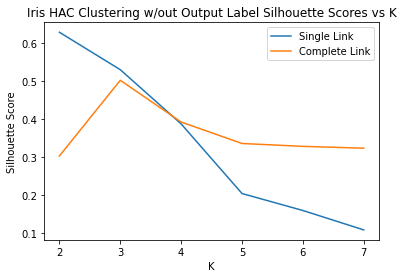

In [25]:
# Graph results
plt.plot(iris_ks, single_sil_scores, label='Single Link')
plt.plot(iris_ks, complete_sil_scores, label='Complete Link')
plt.title('Iris HAC Clustering w/out Output Label Silhouette Scores vs K')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

COMMENT HERE

## 2.1.2 (5%) Clustering the Iris Classification problem - HAC

Requirements:
- Repeat excercise 2.1.1 and include the output label as one of the input features.

In [26]:
# Iris Classification using single-link
single_sil_scores_w_output = []
for k in iris_ks:
    print('Computing hac %d' % k)
    hac = HACClustering(k=k, link_type='single')
    hac.fit(X_iris, y_iris)
    single_sil_scores_w_output.append(hac.silhouette_score)

Computing hac 2
Computing hac 3
Computing hac 4
Computing hac 5
Computing hac 6
Computing hac 7


In [27]:
# Iris Classification using complete-link
complete_sil_scores_w_out = []
for k in iris_ks:
    print('Computing hac %d' % k)
    hac = HACClustering(k=k, link_type='complete')
    hac.fit(X_iris, y_iris)
    complete_sil_scores_w_out.append(hac.silhouette_score)

Computing hac 2
Computing hac 3
Computing hac 4
Computing hac 5
Computing hac 6
Computing hac 7


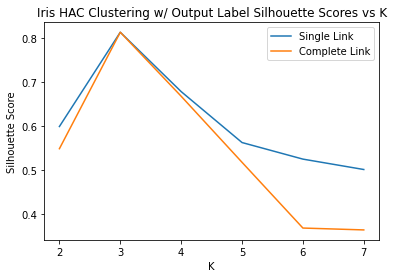

In [28]:
# Graph results
plt.plot(iris_ks, single_sil_scores_w_output, label='Single Link')
plt.plot(iris_ks, complete_sil_scores_w_out, label='Complete Link')
plt.title('Iris HAC Clustering w/ Output Label Silhouette Scores vs K')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

Discuss any differences between the results from 2.1.1 and 2.1.2.

COMMENT HERE

## 2.2.1 (7.5%) Clustering the Iris Classification problem: K-Means

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

Run K-Means on the Iris dataset using the output label as a feature and without using the output label as a feature

Requirements:
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the silhouette score for each k and discuss your results (i.e. what kind of clusters are being made).
---

In [36]:
# Iris Classification without output label
kmeans_sil_scores = []
for k in iris_ks:
    print('Computing kmeans %d' % k)
    kmeans = KMEANSClustering(k=k)
    kmeans.fit(X_iris)
    kmeans_sil_scores.append(kmeans.silhouette_score)

Computing kmeans 2
Computing kmeans 3
Computing kmeans 4
Computing kmeans 5
Computing kmeans 6
Computing kmeans 7


In [30]:
# Iris Classification with output label
kmeans_sil_scores_w_output = []
for k in iris_ks:
    print('Computing kmeans %d' % k)
    kmeans = KMEANSClustering(k=k)
    kmeans.fit(X_iris, y_iris)
    kmeans_sil_scores_w_output.append(kmeans.silhouette_score)

Computing kmeans 2
Computing kmeans 3
Computing kmeans 4
Computing kmeans 5
Computing kmeans 6
Computing kmeans 7


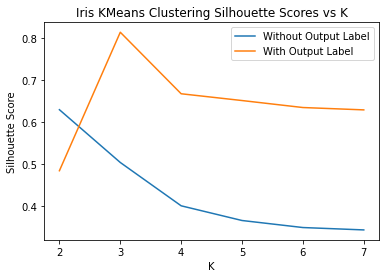

In [37]:
# Graph results
plt.plot(iris_ks, kmeans_sil_scores, label='Without Output Label')
plt.plot(iris_ks, kmeans_sil_scores_w_output, label='With Output Label')
plt.title('Iris KMeans Clustering Silhouette Scores vs K')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

Compare results and differences between using the output label and excluding the output label

COMMENT HERE

## 2.2.2 (5%) Clustering the Iris Classification problem: K-Means

Requirements:
- Use the output label as an input feature
- Run K-Means 5 times with k=4, each time with different initial random centroids and discuss any variations in the results. 

Computing kmeans 0
Computing kmeans 1
Computing kmeans 2
Computing kmeans 3
Computing kmeans 4
Computing kmeans 5


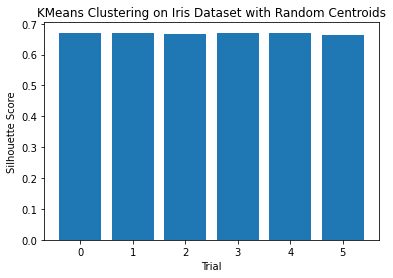

In [83]:
#K-Means 5 times
kmeans_rand_cent_sil_scores = []
trials = np.arange(0, 6)
for trial in trials:
    print('Computing kmeans %d' % trial)
    kmeans = KMEANSClustering(k=4, random_centroids=True)
    kmeans.fit(X_iris, y_iris)
    kmeans_rand_cent_sil_scores.append(kmeans.silhouette_score)

plt.bar(trials, kmeans_rand_cent_sil_scores)
plt.title("KMeans Clustering on Iris Dataset with Random Centroids")
plt.xlabel("Trial")
plt.ylabel("Silhouette Score")
plt.show()

Discuss any variations in the results

COMMENT HERE

## 3.1 (12.5%) Run the SK versions of HAC (both single and complete link) on iris including the output label and compare your results with those above.
Use the silhouette score for this iris problem(k = 2-7).  You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function from [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) and compare the results. State which metric was used. 
- Possible sklean metrics include (* metrics require ground truth labels):
    - adjusted_mutual_info_score*
    - adjusted_rand_score*
    - homogeneity_score*
    - completeness_score*
    - fowlkes_mallows_score*
    - calinski_harabasz_score
    - davies_bouldin_score
- Experiment using different hyper-parameters. Discuss Results

,k,silhouette_score,adjusted_mutual_info_score
0,2,0.598861,0.731585
1,3,0.587823,0.780978
2,4,0.375146,0.712072
3,5,0.228277,0.649346
4,6,0.143093,0.613802
5,7,0.229719,0.615267


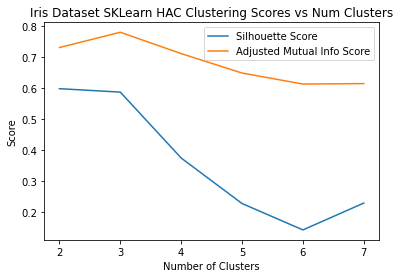

In [107]:
# Load sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_mutual_info_score

hac_data = pd.DataFrame(columns=['k', 'silhouette_score', 'adjusted_mutual_info_score'])

for k in iris_ks:
    hac_clustering = AgglomerativeClustering(n_clusters=k).fit(X_iris, y_iris)
    hac_clustering.labels_
    sil_score = silhouette_score(np.append(X_iris, y_iris, axis=1), hac_clustering.labels_)
    adj_mut_info_score = adjusted_mutual_info_score(y_iris_truth_labels, hac_clustering.labels_)
    hac_data = hac_data.append(pd.DataFrame([[k, sil_score, adj_mut_info_score]], 
                                            columns=['k', 'silhouette_score', 'adjusted_mutual_info_score']), 
                                            ignore_index=True)

display(hac_data)

plt.plot(hac_data.k, hac_data.silhouette_score, label="Silhouette Score")
plt.plot(hac_data.k, hac_data.adjusted_mutual_info_score, label="Adjusted Mutual Info Score")
plt.legend()
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Iris Dataset SKLearn HAC Clustering Scores vs Num Clusters')
plt.show()

*Record impressions*

## 3.2 (12.5%) Run the SK version of k-means on iris including the output label and compare your results with those above. 

Use the silhouette score for this iris problem(k = 2-7). You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function form sklearn.metrics and compare the results. State which metric was used
- Experiment different hyper-parameters. Discuss Results

In [ ]:
# Load sklearn 



*Record impressions*

## 4. (Optional 5% extra credit) For your silhouette experiment above, write and use your own code to calculate the silhouette scores, rather than the SK or other version. 


*Show findings here*

In [ ]:
# Copy function Below